In [1]:
import nidaqmx
import os
import time
import numpy as np
import matplotlib.pyplot as plt

# import pyfirmata
# import time
# board = pyfirmata.Arduino('COM3')

# board.exit()


# task_write0 = nidaqmx.Task()
# task_write0.ao_channels.add_ao_voltage_chan("Dev5/ao1", min_val=0, max_val=5)

# def daq_sqwave(n):
#     for _ in range(n):
#         task_write0.write(5) ## Give Voltage Value for pk-pk (5 V for Marker and 0.5 V for Sync)
#         # task_write0.stop()
#         time.sleep(0.01) ### Pulse width
#         task_write0.write(0)
#         task_write0.stop()
#         # task_dig.stop()
#         time.sleep(0.1) ### Time between two operations of for loop
#         # task_dig.stop()
#     return 'Done'

# task_dig = nidaqmx.Task()
# task_dig.do_channels.add_do_chan('Dev5/port0/line0')

# # task_dig.write(True,auto_start=True)
# # time.sleep(0.01)
# # task_dig.write(False,auto_start=True)

# def daq_sqwave(n):
#     for _ in range(n):
#         task_dig.write(True,auto_start=True) ## 500 mV pk-pk
#         time.sleep(0.05) ### Pulse width
#         # task_write2.stop()
#         # time.sleep(0.0001)


#         task_dig.write(False,auto_start=True)
#         # task_dig.stop()
        
#         # task_write0.stop()
#         task_dig.stop()
#         time.sleep(0.1)
#     return 'Done'
# daq_sqwave(10)
# daq_sqwave(10)

In [2]:
# def ard_sqwave(n):
#     for _ in range(n):
#         board.digital[13].write(1)
#         time.sleep(0.005)
#         board.digital[13].write(0)
#         time.sleep(0.1)
#     return 'Done'
# # ard_sqwave(20)





In [2]:
# for i in range(0, numChannels.value):
#     tryfunc(mhlib.MH_GetCountRate(ct.c_int(dev[0]), ct.c_int(i), byref(countRate)),
#             "GetCountRate")
#     print("Countrate[%1d]=%1d/s" % (i, countRate.value))

import time
import ctypes as ct
from ctypes import byref
import os
import sys

LIB_VERSION = "3.1"
MAXDEVNUM = 2
MODE_HIST = 0
MAXLENCODE = 6
MAXINPCHAN = 64
MAXHISTLEN = 65536
FLAG_OVERFLOW = 0x0001

# Measurement parameters, these are hardcoded since this is just a demo
binning = 0 # you can change this
offset = 0
tacq = 1000 # Measurement time in millisec, you can change this
syncDivider = 2 # you can change this 

syncTriggerEdge = 0 # you can change this, can be set to 0 or 1 
syncTriggerLevel = -50 # you can change this (in mV) 
syncChannelOffset = -5000 # you can change this (in ps, like a cable delay)
inputTriggerEdge = 0 # you can change this, can be set to 0 or 1  
inputTriggerLevel = -50 # you can change this (in mV)
inputChannelOffset = 0 # you can change this (in ps, like a cable delay)

cmd = 0

# Variables to store information read from DLLs
counts = [(ct.c_uint * MAXHISTLEN)() for i in range(0, MAXINPCHAN)]
dev = []
libVersion = ct.create_string_buffer(b"", 8)
hwSerial = ct.create_string_buffer(b"", 8)
hwPartno = ct.create_string_buffer(b"", 8)
hwVersion = ct.create_string_buffer(b"", 8)
hwModel = ct.create_string_buffer(b"", 24)
errorString = ct.create_string_buffer(b"", 40)
numChannels = ct.c_int()
# histLen = ct.c_int()
resolution = ct.c_double()
syncRate = ct.c_int()
countRate = ct.c_int()
flags = ct.c_int()
warnings = ct.c_int()
warningstext = ct.create_string_buffer(b"", 16384)

if os.name == "nt":
    mhlib = ct.WinDLL("mhlib64.dll")
else:
    mhlib = ct.CDLL("libmh150.so")

def closeDevices():
    for i in range(0, MAXDEVNUM):
        mhlib.MH_CloseDevice(ct.c_int(i))
    sys.exit(0)

def tryfunc(retcode, funcName):
    if retcode < 0:
        mhlib.MH_GetErrorString(errorString, ct.c_int(retcode))
        print("MH_%s error %d (%s). Aborted." % (funcName, retcode,
              errorString.value.decode("utf-8")))
        closeDevices()
        
for i in range(0, MAXDEVNUM):
    retcode = mhlib.MH_OpenDevice(ct.c_int(i), hwSerial)
    if retcode == 0:
        print("  %1d        S/N %s" % (i, hwSerial.value.decode("utf-8")))
        dev.append(i)
    else:
        if retcode == -1: # MH_ERROR_DEVICE_OPEN_FAIL
            print("  %1d        no device" % i)
        else:
            mhlib.MH_GetErrorString(errorString, ct.c_int(retcode))
            print("  %1d        %s" % (i, errorString.value.decode("utf8")))

# In this demo we will use the first MultiHarp device we find, i.e. dev[0].
# You can also use multiple devices in parallel.
# You can also check for specific serial numbers, so that you always know 
# which physical device you are talking to.

if len(dev) < 1:
    print("No device available.")
    exit(0)
print("Using device #%1d" % dev[0])
print("\nInitializing the device...")

tryfunc(mhlib.MH_Initialize(ct.c_int(dev[0]), ct.c_int(MODE_HIST), ct.c_int(0)),
        "Initialize")

# Only for information
tryfunc(mhlib.MH_GetHardwareInfo(dev[0], hwModel, hwPartno, hwVersion),
        "GetHardwareInfo")
print("Found Model %s Part no %s Version %s" % (hwModel.value.decode("utf-8"),
      hwPartno.value.decode("utf-8"), hwVersion.value.decode("utf-8")))

tryfunc(mhlib.MH_GetNumOfInputChannels(ct.c_int(dev[0]), byref(numChannels)),
        "GetNumOfInputChannels")
print("Device has %i input channels." % numChannels.value)

tryfunc(mhlib.MH_SetSyncDiv(ct.c_int(dev[0]), ct.c_int(syncDivider)), "SetSyncDiv")

tryfunc(
    mhlib.MH_SetSyncEdgeTrg(ct.c_int(dev[0]), ct.c_int(syncTriggerLevel),
                            ct.c_int(syncTriggerEdge)),
    "SetSyncEdgeTrg"
    )

tryfunc(mhlib.MH_SetSyncChannelOffset(ct.c_int(dev[0]), ct.c_int(syncChannelOffset)),
        "SetSyncChannelOffset")

# we use the same input settings for all channels, you can change this
for i in range(0, numChannels.value):
    tryfunc(
        mhlib.MH_SetInputEdgeTrg(ct.c_int(dev[0]), ct.c_int(i), ct.c_int(inputTriggerLevel),
                                 ct.c_int(inputTriggerEdge)),
        "SetInputEdgeTrg"
    )

    tryfunc(
        mhlib.MH_SetInputChannelOffset(ct.c_int(dev[0]), ct.c_int(i),
                                       ct.c_int(inputChannelOffset)),
        "SetInputChannelOffset"
    )

# tryfunc(mhlib.MH_SetHistoLen(ct.c_int(dev[0]), ct.c_int(MAXLENCODE), byref(histLen)),
#         "SetHistoLen")
# print("Histogram length is %d" % histLen.value)

tryfunc(mhlib.MH_SetBinning(ct.c_int(dev[0]), ct.c_int(binning)), "SetBinning")
tryfunc(mhlib.MH_SetOffset(ct.c_int(dev[0]), ct.c_int(offset)), "SetOffset")
tryfunc(mhlib.MH_GetResolution(ct.c_int(dev[0]), byref(resolution)), "GetResolution")
print("Resolution is %1.1lfps" % resolution.value)

# Note: after Init or SetSyncDiv you must allow >100 ms for valid  count rate readings
time.sleep(0.2)




def countrate(i):
    tryfunc(mhlib.MH_GetCountRate(ct.c_int(dev[0]), ct.c_int(i), byref(countRate)),
            "GetCountRate")
    return countRate.value

countrate(0)


  0        S/N 1044271
  1        no device
Using device #0

Initializing the device...
Found Model MultiHarp 150 4P Part no 930043 Version 1.0
Device has 4 input channels.
Resolution is 5.0ps


7630

In [3]:
from AMC_python import AMC
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

# import time

IP = "192.168.1.1"

# Setup connection to AMC
amc = AMC.Device(IP)
amc.connect()

# Activate axis 1
# Internally, axes are numbered 0 to 2
axis0 = 0 # Axis 1
amc.control.setControlOutput(axis0, True)

# Activate axis 2
axis1 = 1 # Axis 2
amc.control.setControlOutput(axis1, True)

axis2 = 2 # Axis 2
amc.control.setControlOutput(axis2, True)



from IPython.display import clear_output
# y_move = 10
# x_move = 19
### RASTER SCAN FUNCTION: Run this before next kernel
# cbm = CountBetweenMarkers(tt, SPD_CH, PIXEL_START_CH, PIXEL_STOP_CH, n_pixels)

def raster_scan(x_move,y_move,x_step,y_step):
    # count_data = cbm.getData()
    
    # x_step = 1
    # y_step = 50
    pos_xy = []
    counts_xy = []
    counts = np.zeros((y_move,x_move+1))
    # img = np.reshape(counts, (ny_pix, nx_pix))
    # img[1::2,:] = np.fliplr(img[1::2,:])
    
    # clear_output(wait=True)
    # pos_xy = [(0,0)]*(y_move*(x_move+1))
    # plt.plot(*zip(*pos_xy),'g.')
    # plt.show()
    # j = 0
    # pos_xy = [(amc.move.getPosition(axis0),amc.move.getPosition(axis1))]
    amc.control.setControlAmplitude(axis1,24000) #22500 #35000 #25000 
    m = 0
    for i in range(y_move):
        x = i
        amc.move.setNSteps(axis1, False, y_step) ## Moves Up == False
        # amc.move.setNSteps(axis1, True, y_step)  ## Moves Down == True
        # cbm.getData()
        # ard_sqwave(1) ## DAQ trigger
        time.sleep(0.2) ## stop time in seconds
        pos_xy.append((amc.move.getPosition(axis0),amc.move.getPosition(axis1)))
        counts_xy.append((amc.move.getPosition(axis0),amc.move.getPosition(axis1),countrate(0)))
        
        clear_output(wait=True)
        if x%2 == 1:
            counts[i,x_move] = countrate(0)
        else:
            counts[i,0] = countrate(0)
        plt.imshow(counts)
        # cbar = colorbar(img)
        
        # counts[i,m] = countrate(0)
        # plt.plot(*zip(*pos_xy),'.r')
        plt.show()
        
        # pos_xy[m] = (amc.move.getPosition(axis0),amc.move.getPosition(axis1))
        # print(m)
        # print((amc.move.getPosition(axis0),amc.move.getPosition(axis1)))
        # print(count_data)
        # m = m+1
        for j in range(x_move):
            # amc.move.setNSteps(axis0, x%2, x_step)
            if x%2 == 1:
                ### BACKWARD
                amc.control.setControlAmplitude(axis0,34301) ## Changes amplitude in back (x avis) #22600 #25000 34300
                # amc.control.setControlFrequency(axis0,999000)
            else:
                ### FORWARD
                amc.control.setControlAmplitude(axis0,42301)  ## Changes amplitude in fwd (x avis) #27301 #29501  42301
                # amc.control.setControlFrequency(axis0,999000)
                
            amc.move.setNSteps(axis0, x%2, x_step)  ## Moves in x
            # pos_xy[m] = (amc.move.getPosition(axis0),amc.move.getPosition(axis1))
            # print(m)
            # ard_sqwave(1) ## DAQ trigger
            time.sleep(0.2) ## stop time in seconds
            pos_xy.append((amc.move.getPosition(axis0),amc.move.getPosition(axis1)))
            counts_xy.append((amc.move.getPosition(axis0),amc.move.getPosition(axis1),countrate(0)))

            clear_output(wait=True)
            if x%2 == 0:
                counts[i,j+1] = countrate(0)
            else:
                counts[i,x_move-(j+1)] = countrate(0)
            
            # counts[1::2,:] = np.fliplr(counts[1::2,:])
            # if x%2 == 1:
            #     counts[i,y_move-(j+1)] = countrate(0)
            # else:
            #     counts[i,j+1] = countrate(0)
            plt.imshow(counts)
            # cbar = colorbar(img)
            
            # plt.plot(*zip(*pos_xy),'.r')
            plt.show()
            # print(j,i,amc.control.getControlAmplitude(axis0),(amc.move.getPosition(axis0),amc.move.getPosition(axis1)))
            # pos_xy.append((amc.move.getPosition(axis0),amc.move.getPosition(axis1),cbm.getData()[m]))
            # print(j,i,amc.control.getControlAmplitude(axis0),(amc.move.getPosition(axis0),amc.move.getPosition(axis1)),cbm.getData()[m])
            # # print(count_data)
            
        # m = m+1
           
            # pos_x.append(amc.move.getPosition(axis0))
        # print('Pos_x: ',amc.move.getPosition(axis0))
        # pos_xy.append((amc.move.getPosition(axis0),amc.move.getPosition(axis1)))
        # amc.move.setNSteps(axis1, False, y_step)
        # pos_xy.append((amc.move.getPosition(axis0),amc.move.getPosition(axis1)))
        # print(j,i,(amc.move.getPosition(axis0),amc.move.getPosition(axis1)))
        # # daq_sqwave(1)
        # time.sleep(0.5)
    # return print('Scan Over')
    # cbm.stop()
    # clear_output
    img = plt.imshow(counts)
    cbar = plt.colorbar(img)
    plt.show()
    print(pos_xy[0])
    return counts_xy

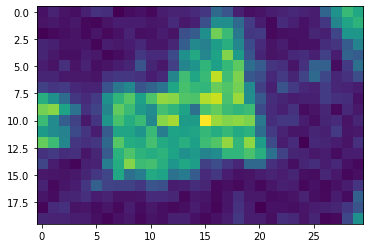

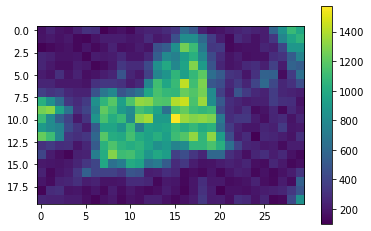

(-8719820.481, -2534183.426)
Your file is saved as: D:\Data\January-2023\20230124\MoSe2_scan9_MH_XY.csv


In [112]:
x_step = 1 #
y_step = 1
y_move = int(input("No. of steps in y:"))
x_move = int(input("No. of steps in x:"))
save = input("Do you want to save the xy data for this scan (y or n)?")
from datetime import datetime
date = datetime.today().strftime('%Y%m%d') #'20221207'
folder_name = datetime.today().strftime('%B-%Y') #'20221207'
if save == 'y':
    sample = input("Sample name (without space):")
    scan_num = input("Scan number: ")
    
# print(save.type)

# while cbm.isRunning():
#     clear_output(wait=True)
    
#     # time.sleep(10)
#     img = cr.getData()
#     plt.plot(range(img.shape[1]),img[0][range(img.shape[1])])
#     plt.show()
# clear_output(wait=True)
# plt.plot(*zip(*p),'g.')
# plt.show()
p = raster_scan(x_move,y_move,x_step,y_step)
# print(p[0])
if save == 'y':
    import pandas as pd
    df = pd.DataFrame(p, columns = ['X_data','Y_data','Intensity'])

    # # path = 'C:\\Users\\Praveen\\Desktop\\NVspectrum\\September-2022\\28_10_2022'
    path = 'D:\\Data\\'+folder_name+'\\'+date
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)

    df.to_csv(path+'\\'+sample+'_scan'+str(scan_num)+'_MH_XY.csv', index=False)
    xy = [(i[0],i[1]) for i in p]
    print('Your file is saved as:',path+'\\'+sample+'_scan'+str(scan_num)+'_MH_XY.csv')    

# l1 = [0]*(y_move*y_move)
# l2 = l1
# len(list(zip(l1,l2)))

Your file is saved as: D:\Data\January-2023\20230124\MoSe2_scan9_MH_XY.csv


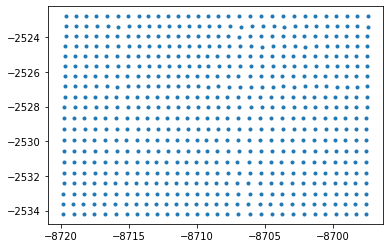

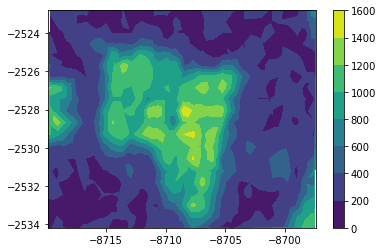

In [113]:
import pandas as pd
df = pd.DataFrame(p, columns = ['X_data','Y_data','Intensity'])

# # path = 'C:\\Users\\Praveen\\Desktop\\NVspectrum\\September-2022\\28_10_2022'
path = 'D:\\Data\\'+folder_name+'\\'+date
isExist = os.path.exists(path)
if not isExist:
    os.makedirs(path)

df.to_csv(path+'\\'+sample+'_scan'+str(scan_num)+'_MH_XY.csv', index=False)
xy = [(i[0],i[1]) for i in p]
print('Your file is saved as:',path+'\\'+sample+'_scan'+str(scan_num)+'_MH_XY.csv')    

dataxy = np.genfromtxt(path+"\\"+sample+"_scan"+str(scan_num)+"_MH_XY.csv",delimiter=',').T

datax = [(i)/1000 for i in dataxy[0][1:]] #-dataxy[0][1]
datay = [(i)/1000 for i in dataxy[1][1:]] #-dataxy[1][1]
counts = [i for i in dataxy[2][1:]] #-dataxy[1][1]

# x = len(datax)-len(counts_sum)
# for _ in range(x):
#     counts_sum.append(0)

import matplotlib.pyplot as plt
plt.plot(datax,datay,'.')
plt.show()
img = plt.tricontourf(datax,datay,counts)
cbar = plt.colorbar(img)
plt.savefig(path+"\\test"+str(scan_num)+"_"+sample+"_MH.png",format='png')


In [4]:
# board.exit()
# amc.close()
closeDevices()

SystemExit: 0

C:\Users\Praveen\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


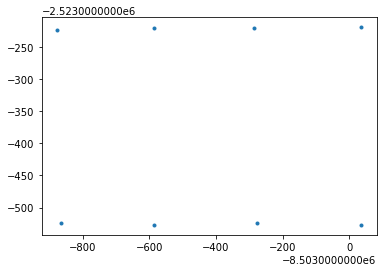

In [61]:
p[0][0]-p[1][0]
p[4][0]-p[5][0]
plt.plot(*zip(*[(p[i][0],p[i][1]) for i in range(len(p))]),'.')
# p

In [44]:
folder_name = datetime.today().strftime('%B-%Y') #'20221207'
# file_name
path = 'D:\\Data\\'+folder_name+'\\'+date


Your file is saved as: D:\Data\December-2022\20221208\Dye_scan1_MH_XY.csv


In [38]:
# print(p[1][0]-p[2][0],p[13][0]-p[14][0],p[1][1]-p[13][1])
p[0]

(-2920591.279, -763335.997)

In [24]:
board.exit()

In [136]:
###########################  END  ########################################

In [134]:
## Return to XY ref positions
ref_posx = -2920591 #-589350 #nm
amc.move.setControlTargetPosition(axis0, ref_posx)
amc.control.setControlMove(axis0, True)


In [39]:
# ref_posy = 368485 #nm
# amc.move.setControlTargetPosition(axis1, ref_posy)
# amc.control.setControlMove(axis1, False)
for i in range(y_move):    
    amc.move.setNSteps(axis1, True, y_step)

In [40]:
# p[0][1]-p[1][1]

# p
# df = pd.DataFrame(p, columns = ['X_data','Y_data'])
# scan_num = 5

#     # # path = 'C:\\Users\\Praveen\\Desktop\\NVspectrum\\September-2022\\28_10_2022'
# path = 'D:\\Data\\November-2022\\'+date
# df.to_csv(path+'\\'+sample+'_scan'+str(scan_num)+'_MH_XY.csv', index=False)

-196.77700000000186 237.35899999993853 205.44099999999162


In [26]:
x_move = 9
y_move = 10
l1 = [(0,0)]*(y_move*(x_move+1))
# len(l1)
l1[0] = (1,2)

# print(l1)
